In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


In [18]:
df = pd.read_csv('../data/steam-200k.csv', header=None, names=['user-id', 'game-title', 'behaviour', 'value', 'extra'])
df.head()

,user-id,game-title,behaviour,value,extra
0,151603712,The Elder Scrolls V Skyrim,purchase,1.0,0
1,151603712,The Elder Scrolls V Skyrim,play,273.0,0
2,151603712,Fallout 4,purchase,1.0,0
3,151603712,Fallout 4,play,87.0,0
4,151603712,Spore,purchase,1.0,0


In [ ]:
df.drop(columns=['extra'], inplace=True)

In [33]:
missing = df.isnull().sum()
print("Missing values in each column:\n")
print(missing)

Missing values in each column:

user-id       0
game-title    0
behaviour     0
value         0
dtype: int64


In [20]:
exact_dupes = df.duplicated().sum()
print(f"Exact duplicate rows: {exact_dupes}")

partial_dupes = df.duplicated(subset=['user-id', 'game-title', 'behaviour']).sum()
print(f"Partial duplicates (same user+game+behaviour): {partial_dupes}")


Exact duplicate rows: 707
Partial duplicates (same user+game+behaviour): 719


In [23]:
df.shape


(200000, 4)

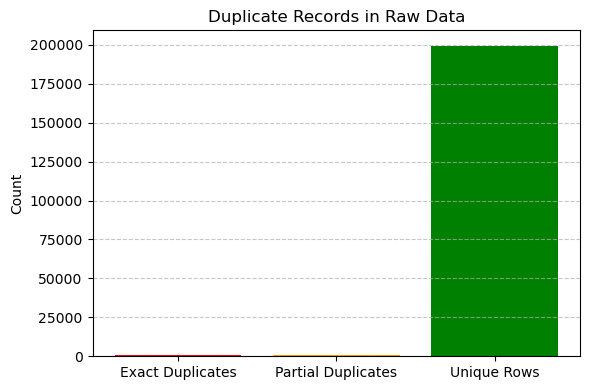

In [ ]:
dupes = {
    'Exact Duplicates': exact_dupes,
    'Partial Duplicates': partial_dupes,
    'Unique Rows': len(df) - exact_dupes
}

plt.figure(figsize=(6,4))
plt.bar(dupes.keys(), dupes.values(), color=['red', 'orange', 'green'])
plt.title('Duplicate Records in Raw Data')
plt.ylabel('Count')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


In [7]:
# Group by user+game+action and count occurrences
dup_patterns = df.groupby(['user_id', 'game', 'action']).size().reset_index(name='count')
multi_entries = dup_patterns[dup_patterns['count'] > 1]
print(f"User-game-action pairs with multiple entries: {len(multi_entries)}")

# Optional: show a few
multi_entries.sample(5)


User-game-action pairs with multiple entries: 719


,user_id,game,action,count
120217,110906645,Grand Theft Auto San Andreas,purchase,2
170653,189858084,Grand Theft Auto III,purchase,2
28253,29753085,Grand Theft Auto III,purchase,2
12782,12144171,Grand Theft Auto III,purchase,2
146749,150882304,Sid Meier's Civilization IV,purchase,2


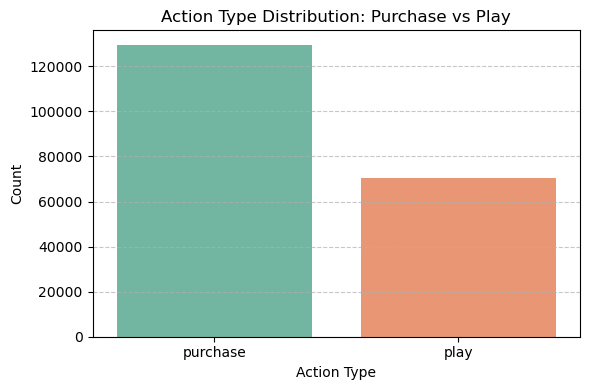

In [24]:
action_counts = df['behaviour'].value_counts()

plt.figure(figsize=(6,4))
sns.barplot(x=action_counts.index, y=action_counts.values, palette='Set2')

plt.title('Action Type Distribution: Purchase vs Play')
plt.xlabel('Action Type')
plt.ylabel('Count')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [35]:
df.drop_duplicates()

,user-id,game-title,behaviour,value
0,151603712,The Elder Scrolls V Skyrim,purchase,1.0
1,151603712,The Elder Scrolls V Skyrim,play,273.0
2,151603712,Fallout 4,purchase,1.0
3,151603712,Fallout 4,play,87.0
4,151603712,Spore,purchase,1.0
...,...,...,...,...
199995,128470551,Titan Souls,play,1.5
199996,128470551,Grand Theft Auto Vice City,purchase,1.0
199997,128470551,Grand Theft Auto Vice City,play,1.5
199998,128470551,RUSH,purchase,1.0


In [40]:
purchases = df[df['behaviour'] == 'purchase']
purchases_cleaned = purchases.drop_duplicates(subset=['user-id', 'game-title'])

In [41]:
plays = df[df['behaviour'] == 'play']
plays_cleaned = plays.groupby(['user-id', 'game-title']).agg({'value': 'sum'}).reset_index()
plays_cleaned['behaviour'] = 'play'



In [42]:
final_df = pd.concat([purchases_cleaned, plays_cleaned], ignore_index=True)

final_data = final_df.sort_values(by='user-id')

final_data.to_csv('../results/steam_cleaned.csv', index=False)


In [43]:
print("Exact duplicate rows:", final_df.duplicated().sum())


Exact duplicate rows: 0


In [44]:
final_df[final_df['behaviour'] == 'purchase'].duplicated(subset=['user-id', 'game-title']).sum()


0

In [45]:
final_df[final_df['behaviour'] == 'play'].duplicated(subset=['user-id', 'game-title']).sum()


0

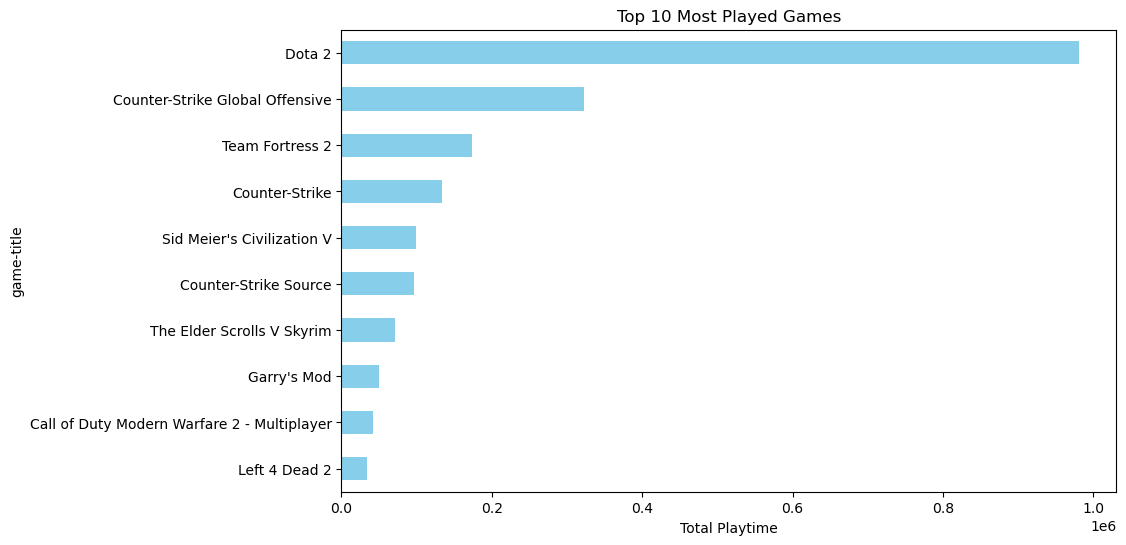

In [46]:
top_games = final_df[final_df['behaviour'] == 'play'] \
    .groupby('game-title')['value'].sum() \
    .sort_values(ascending=False).head(10)

top_games.plot(kind='barh', figsize=(10,6), title='Top 10 Most Played Games', color='skyblue')
plt.xlabel('Total Playtime')
plt.gca().invert_yaxis()
plt.show()

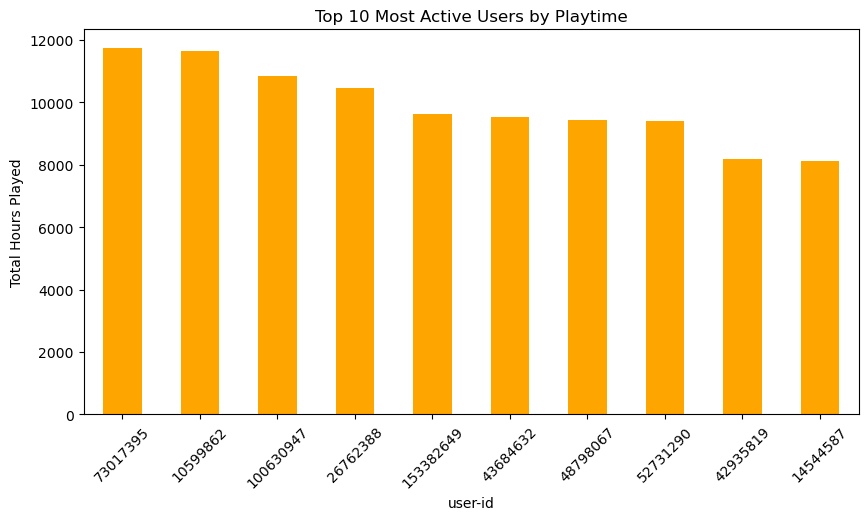

In [47]:
top_users = final_df[final_df['behaviour'] == 'play'] \
    .groupby('user-id')['value'].sum() \
    .sort_values(ascending=False).head(10)

top_users.plot(kind='bar', figsize=(10,5), title='Top 10 Most Active Users by Playtime', color='orange')
plt.ylabel('Total Hours Played')
plt.xticks(rotation=45)
plt.show()
